In [163]:
import json
import os
import torch
import numpy as np
import cv2
import albumentations
import albumentations.pytorch
# from torchvision.io import read_image

class Radiate_Dataset(torch.utils.data.Dataset):
    def __init__(self, data_folder, train_mode, transform = False):
        self.root_dir = data_folder
        self.folders = []
        self.transform = transform
        # print(len(os.listdir(self.root_dir)))
        self.train_mode = train_mode
        for curr_dir in os.listdir(self.root_dir):
            with open(os.path.join(self.root_dir, curr_dir, 'meta.json')) as f:
                meta = json.load(f)
            if meta["set"] == train_mode:
                self.folders.append(curr_dir)
        self.folders.sort()
        # print(self.folders)
        # print(len(self.folders))
        
        self.radar_dicts = self.get_radar_dicts(self.folders)
        # print(len(self.radar_dicts))
        # self.datas = []
        self.data_idx = 0        
        # for idx, _ in enumerate(self.radar_dicts):
        #     record_init = {}
        #     record_init["data_idx"] = self.data_idx
        #     record_init["img"] = self.radar_dicts[idx]
        #     record_init["train_mode"] = self.train_mode
        #     self.data_idx += 1
        #     self.datas.append(record_init)
        
    def __len__(self):
        return len(self.radar_dicts)
    
    def __getitem__(self, idx):
        radar_dict = self.radar_dicts[idx]
        img = cv2.imread(radar_dict["file_name"])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # print(radar_dict["img"])
        boxes = []
        bbox_OOD = []
        category_id = []
        angle = []
        target = {}
        img_info = {}
        num_objs = 0
        difficulties = []

        for i in range(len(radar_dict['annotations'])):
            boxes.append(radar_dict['annotations'][i]['bbox'])
            angle.append(radar_dict['annotations'][i]['angle'])
            bbox_OOD.append(radar_dict['annotations'][i]['bbox_OOD'])
            category_id.append(radar_dict['annotations'][i]['category_id'])
            
            difficulties.append(['0'])
            num_objs += 1
        
        boxes = torch.as_tensor(boxes, dtype = torch.float32)
        angle = torch.as_tensor(angle, dtype = torch.float32)
        bbox_OOD = torch.as_tensor(bbox_OOD, dtype = torch.float32)
        category_id = torch.as_tensor(category_id, dtype = torch.float32)
        iscrowd = torch.zeros((num_objs,), dtype = torch.int64)
    
        target["file_name"] = radar_dict['file_name']
        target["frame_number"] = radar_dict['frame_number']
        target["folder_name"] = radar_dict['folder_name']
        target["bboxes"] = boxes
        target["angle"] = angle
        target["bboxes_OOD"] = bbox_OOD
        target["category_id"] = category_id
        target['image_id'] = radar_dict['image_id']
        # target["iscrowd"] = iscrowd 
        target["difficulty"] = difficulties
        # labels = category_id
        img_info["folder_name"] = radar_dict['folder_name']
        img_info["frame_number"] = radar_dict['frame_number']
        if self.transform:
            data_transform = albumentations.Compose([
                albumentations.CenterCrop(224,224)],
                # albumentations.pytorch.transforms.ToTensorV2()],
                bbox_params=albumentations.BboxParams(format='pascal_voc', label_fields=['labels']),
                )

            transformed = data_transform(image = img, bboxes = target['bboxes'], labels = target["category_id"])
            img = transformed['image']
            target['bboxes'] = torch.as_tensor(transformed['bboxes'], dtype=torch.float32)
            target['category_id'] = torch.as_tensor(transformed['labels'], dtype=torch.float32)
            # labels = transformed['labels']
        
        return img, target, img_info
    


    def gen_boundingbox(self, bbox, angle):
        theta = np.deg2rad(-angle)
        R = np.array([[np.cos(theta), -np.sin(theta)],
                      [np.sin(theta), np.cos(theta)]])
        points = np.array([[bbox[0], bbox[1]],
                           [bbox[0] + bbox[2], bbox[1]],
                           [bbox[0] + bbox[2], bbox[1] + bbox[3]],
                           [bbox[0], bbox[1] + bbox[3]]]).T

        cx = bbox[0] + bbox[2] / 2
        cy = bbox[1] + bbox[3] / 2
        T = np.array([[cx], [cy]])

        points = points - T
        points = np.matmul(R, points) + T
        points = points.astype(float)
        
        return points

    def get_radar_dicts(self, folders):
        dataset_dicts = []
        idd = 0
        folder_size = len(folders)
        file_lenght = 0
        for idx, folder in enumerate(folders):
            radar_folder = os.path.join(self.root_dir, folder, 'Navtech_Cartesian')
            annotation_path = os.path.join(self.root_dir,
                                           folder, 'annotations', 'annotations.json')
            with open(annotation_path, 'r') as f_annotation:
                annotation = json.load(f_annotation)

            folder_number = idx
            radar_files = os.listdir(radar_folder)
            radar_files.sort()
            # print(radar_files)
            
            for frame_number in range(len(radar_files)):
                # if folder_number == 0:
                #     print(frame_number)
                record = {}
                objs = []
                bb_created = True
                idd += 1
                filename = os.path.join(
                    radar_folder, radar_files[frame_number])
                # print(filename)
                if (not os.path.isfile(filename)):
                    print(filename)
                    continue
                record["folder_name"] = folder
                record["frame_number"] = radar_files[frame_number]
                record["file_name"] = filename
                record["image_id"] = idd-1
                record["height"] = 1152
                record["width"] = 1152
                record["folder_number"] = folder_number

                for object in annotation:
                    if (object['bboxes'][frame_number]):
                        class_obj = object['class_name']
                        if (class_obj != 'pedestrian' and class_obj != 'group_of_pedestrians'):
                            bbox = object['bboxes'][frame_number]['position']
                            angle = object['bboxes'][frame_number]['rotation']
                            # bb_created = True
                            # if cfg.MODEL.PROPOSAL_GENERATOR.NAME == "RRPN":
                            x_min = bbox[0]
                            y_min = bbox[1]
                            x_max = bbox[0] + bbox[2]
                            y_max = bbox[1] + bbox[3]
                            if x_min < 0:
                                x_min = 0
                            if y_min < 0:
                                y_min = 0
                            if x_max > 1152:
                                x_max = 1152
                            if y_max > 1152:
                                y_max = 1152
                            # print(bbox, angle.shape)
                            points = self.gen_boundingbox(bbox, angle)
                            x1 = points[0][0]
                            y1 = points[1][0]
                            x2 = points[0][1]
                            y2 = points[1][1]
                            x3 = points[0][2]
                            y3 = points[1][2]
                            x4 = points[0][3]
                            y4 = points[1][3]
                            
                            obj = {
                                "bbox": [x_min, y_min, x_max, y_max],
                                "angle": angle,
                                "bbox_OOD": [x1, y1, x2, y2, x3, y3, x4, y4],
                                "category_id": 0,
                                "iscrowd": 0
                            }

                            objs.append(obj)
                # if bb_created:
                record["annotations"] = objs
                dataset_dicts.append(record)
        # print(dataset_dicts)
        return dataset_dicts
    
    def collate_fn(self, batch):
        num_images = len(batch)
        images = list()
        bboxes = torch.Tensor(num_images, 32, 4).zero_()
        category_id = torch.Tensor(num_images, 32).zero_()
        # bboxes = list()
        # category_id = list()
        
        for i in range(len(batch)):
            images.append(batch[i][0])
            # bboxes.append(batch[i][1])
            # category_id.append(batch[i][2])
            num_boxes = min(batch[i][1].size(0),32)
            if num_boxes == 0:
                continue
            bboxes[i, :num_boxes, :] = batch[i][1][:num_boxes, :]
            category_id[i, :num_boxes] = batch[i][2][:num_boxes]

        images = torch.stack(images, dim=0).contiguous()

        return images, bboxes, category_id


In [73]:
# from dataset import Radiate_Dataset
import torch
import albumentations
import argparse
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import PIL
import numpy as np
import cv2

parser = argparse.ArgumentParser()
parser.add_argument("--data_folder", help="root folder with radiate dataset", 
                    default='/workspace/dataset/radiate', type=str)

parser.add_argument("--save_folder", help="root for save directory",
                    default = "/workspace/JS/faster_rcnn_JS/checkpoint", type=str)

parser.add_argument("--backbone", help="backbone network",
                    default='VGG16', type=str)

parser.add_argument("--mgpu", help="using multigpu",
                    default=False, type=bool)

parser.add_argument("--train_mode", help="dataset mode ('train_good_weather', 'train_good_and_bad_weather', 'test')",
                    default='train_good_and_bad_weather', type=str)

parser.add_argument("--checkpoint", help="checkpoint root",
                    default=None, type=str)

parser.add_argument("--batch_size", help="batch size",
                    default=4, type=int)

parser.add_argument("--num_workers", help="number of workers for loading data in the DataLoader",
                    default=8, type=int)

parser.add_argument("--save_rate", help="save rate for the model",
                    default=5000, type=int)

parser.add_argument("--max_iter", help="Maximum number of iterations",
                    default = 50000, type=int)

parser.add_argument("--loss_lambda", help="loss balance coefficient",
                    default=1, type=int)

parser.add_argument("--lr", help="learning rate",
                    default=0.00025, type=float)

parser.add_argument("--momentum", help="momentum",
                    default=0.9, type=float)

parser.add_argument("--weight_decay", help="weight decay",
                    default=0.0001, type=float)

parser.add_argument("--GAMMA", help="lr GAMMA",
                    default=0.1, type=float)

parser.add_argument("--decay_step", help="steps for decay lr",
                    default=[25000, 35000], type=list)


args = parser.parse_args(args=[])
data_folder = args.data_folder
train_mode = args.train_mode

save_folder = args.save_folder
backbone = args.backbone
checkpoint = args.checkpoint
mgpu = args.mgpu

batch_size = args.batch_size
workers = args.num_workers
max_iteration = args.max_iter
save_rate = args.save_rate

loss_lambda = args.loss_lambda
momentum = args.momentum
lr = args.lr
weight_decay = args.weight_decay
decay_step = args.decay_step
decay_GAMMA = args.GAMMA

In [74]:
# len(x1)


In [42]:
# good_and_bad : 9760
# good_weather: 22371
# test: 11307

In [60]:
import shutil
from tqdm import tqdm
import json
root_path = '/workspace/dataset/radiate_yolov5/'
label_path = '/workspace/dataset/radiate_yolov5/'
dataset_gb = Radiate_Dataset(data_folder, train_mode, transform=False)

# i = 15502
for i in tqdm(range(len(dataset_gb))):
    img, target, img_info= dataset_gb[i]
    file_name = target['file_name']
    folder_name = target['folder_name']
    frame_number= target['frame_number']
    train_mode = target['train_mode']
    bbox = target['bboxes']
    bbox_OBB = target['bboxes_OOD']
    category = target['category_id']
    # print(category.shape)
    img_save_path = os.path.join(root_path, train_mode, str(i).zfill(5)+'.png')
    label_save_path = os.path.join(root_path, train_mode, 'labels',str(i).zfill(5)+'.txt')
    label_OOD_save_path = os.path.join(root_path, train_mode, 'labels_OOD',str(i).zfill(5)+'.txt')
    # print(img_save_path)
    # shutil.copy2(file_name, img_save_path)
    with open(label_save_path,"w") as f:
        for j in range(category.size(0)):
            # print("%i %.6f %.6f %.6f %.6f" % (category[j], bbox[j][0], bbox[j][1], bbox[j][2], bbox[j][3]))
            # print(str(np.array(category[j]).astype(np.int32)))
            f.write("%i %.6f %.6f %.6f %.6f \n" % (category[j], bbox[j][0], bbox[j][1], bbox[j][2], bbox[j][3]))
    
    with open(label_OOD_save_path,"w") as f:
        for j in range(category.size(0)):
            # print("%i %.6f %.6f %.6f %.6f" % (category[j], bbox[j][0], bbox[j][1], bbox[j][2], bbox[j][3]))
            # print(str(np.array(category[j]).astype(np.int32)))
            f.write("%.1f %.1f %.1f %.1f %.1f %.1f %.1f %.1f vehicle %i \n" % (bbox_OBB[j][0], bbox_OBB[j][1], bbox_OBB[j][2], bbox_OBB[j][3], bbox_OBB[j][4], bbox_OBB[j][5], bbox_OBB[j][6], bbox_OBB[j][7], 0))
    

KeyboardInterrupt: 

In [130]:
dataset_g = Radiate_Dataset(data_folder, 'train_good_weather', transform=False)
# dataset_g_nt = Radiate_Dataset(data_folder, 'train_good_weather', transform=False)

# dataset_t = Radiate_Dataset(data_folder, 'test', transform=False)

# len(dataset_gb)

In [69]:
img, target, img_info = dataset_g[1000]
print(target)
print(img_info)
print(len(dataset_g), len(dataset_t))
# PIL.

{'file_name': '/workspace/dataset/radiate/city_1_1/Navtech_Cartesian/000287.png', 'frame_number': '000287.png', 'folder_name': 'city_1_1', 'bboxes': tensor([[ 70.8771,   4.1130,  16.3862,  30.1903],
        [113.3530,  41.5738,  17.2654,  30.8200],
        [172.3094,  13.5146,  21.4499,  30.7896],
        [211.8120,  18.9914,  12.1880,  33.0107],
        [132.1457,  22.7471,  16.4804,  29.6359],
        [156.2231, 120.0107,  19.0375,  30.0596],
        [173.6324,   0.0000,  15.0000,  26.0886],
        [209.1498,   0.0000,  14.8502,  28.2661]]), 'angle': tensor([ 36.3615,  38.2366,  26.2734,  36.0482,  43.3733,  93.6075,  99.6288,
        103.7276, 359.8968,  25.4863,   0.0000,  42.5389,   0.0000,   0.0000,
        134.4927,  94.2277,  97.4204]), 'bboxes_OOD': tensor([[519.3298, 460.8145, 532.5254, 451.0995, 550.4246, 475.4116, 537.2289,
         485.1266],
        [483.7961, 423.5956, 496.9419, 413.2373, 513.6342, 434.4215, 500.4884,
         444.7798],
        [562.7908, 495.5771, 578

In [43]:
f  = np.loadtxt('/workspace/dataset/radiate_yolov5/train_good_weather/labels/000000.txt',dtype = np.float32)
print(f[1])
# print(line[2])

0.877043


In [7]:
folders = os.listdir(data_folder)
folders.sort()
total_length = 0
for idx, folder in enumerate(folders):
    radar_folder = os.path.join(data_folder, folder, 'Navtech_Cartesian')
    annotation_path = os.path.join(data_folder, folder, 'annotations', 'annotations.json')
    with open(annotation_path, 'r') as f_annotation:
        annotation = json.load(f_annotation)

    folder_number = idx
    radar_files = os.listdir(radar_folder)
    radar_files.sort()
    print(folder, len(radar_files))
    total_length += len(radar_files)
    
print(total_length)


city_1_0 714
city_1_1 721
city_1_3 720
city_2_0 707
city_3_0 713
city_3_1 716
city_3_2 724
city_3_3 720
city_3_7 720
city_4_0 1101
city_5_0 563
city_6_0 745
city_7_0 605
fog_6_0 714
fog_8_0 710
fog_8_1 720
fog_8_2 434
junction_1_0 714
junction_1_1 721
junction_1_10 718
junction_1_11 727
junction_1_12 722
junction_1_13 722
junction_1_14 723
junction_1_15 583
junction_1_2 723
junction_1_3 723
junction_1_4 722
junction_1_5 722
junction_1_6 722
junction_1_7 719
junction_1_8 727
junction_1_9 723
junction_2_0 711
junction_2_1 719
junction_2_2 720
junction_2_3 720
junction_2_5 720
junction_2_6 586
junction_3_0 718
junction_3_1 725
junction_3_2 724
junction_3_3 547
motorway_1_0 713
motorway_2_0 715
motorway_2_1 715
motorway_2_2 726
night_1_0 713
night_1_1 722
night_1_2 723
night_1_3 722
night_1_4 722
night_1_5 720
rain_2_0 2270
rain_3_0 47
rain_4_0 711
rain_4_1 720
rural_1_1 720
rural_1_3 722
snow_1_0 691
tiny_foggy 18
43438


In [28]:
print(len(dataset_g))
print(len(dataset_gb))
print(len(dataset_t))

22371
9760
11307


In [28]:
from PIL import Image
j = 1300
# for i in range(len(x1)):

img, target, _ = dataset_g[j]

# file_name = target['file_name']
# folder_name = target['folder_name']
# frame_number= target['frame_number']
# train_mode = target['train_mode']
# bbox = target['bboxes']
# category = target['category_id']

img1_p = img
# img1_p = img1_p.detach().cpu().numpy()
# img1_p = np.transpose(img1_p, (1,2,0))
img1_p = cv2.cvtColor(img1_p, cv2.COLOR_BGR2RGB)
img1_p = img1_p.astype(np.uint8).copy()
bbox = np.loadtxt('/workspace/dataset/radiate_yolov5/'+train_mode+'/labels_OOD/'+str(j).zfill(6)+'.txt',dtype='str')
bboxes = np.loadtxt('/workspace/dataset/radiate_yolov5/'+train_mode+'/labels/'+str(j).zfill(6)+'.txt',dtype = np.float32)
try:
    print(bbox.shape)
    print(bboxes.shape)

    temp = bbox[:,0:8]
    bbox = temp.astype(np.float32)
    bbox = bbox.astype(np.int32)
    bboxes = torch.from_numpy(bboxes)
    # print(bboxes.size())
    rec = bboxes*1152
    rec = np.int32(rec)

    # print(rec[0][0], rec[0][1], rec[0][2], rec[0][3])
    for i, _ in enumerate(bbox):
        cv2.line(img1_p, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), (255,0,0), 4)
        cv2.line(img1_p, (bbox[i][2], bbox[i][3]), (bbox[i][4], bbox[i][5]), (255,0,0), 4)
        cv2.line(img1_p, (bbox[i][4], bbox[i][5]), (bbox[i][6], bbox[i][7]), (255,0,0), 4)
        cv2.line(img1_p, (bbox[i][6], bbox[i][7]), (bbox[i][0], bbox[i][1]), (255,0,0), 4)
        
        x1 = int(rec[i][1] - rec[i][3]/2)
        x2 = int(rec[i][1] + rec[i][3]/2)
        y1 = int(rec[i][2] - rec[i][4]/2)
        y2 = int(rec[i][2] + rec[i][4]/2)

        cv2.rectangle(img1_p, (x1, y1), (x2, y2), color = (255,255,0))
# break
    img1_show = Image.fromarray(img1_p)
    img1_show.show()
except:
    
    if bbox.shape[0] == 10:
        temp = bbox[0:8]
        bbox = temp.astype(np.float32)
        bbox = bbox.astype(np.int32)
        bboxes = torch.from_numpy(bboxes)
        # print(bboxes.size())
        rec = bboxes*1152
        rec = np.int32(rec)
        cv2.line(img1_p, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255,0,0), 4)
        cv2.line(img1_p, (bbox[2], bbox[3]), (bbox[4], bbox[5]), (255,0,0), 4)
        cv2.line(img1_p, (bbox[4], bbox[5]), (bbox[6], bbox[7]), (255,0,0), 4)
        cv2.line(img1_p, (bbox[6], bbox[7]), (bbox[0], bbox[1]), (255,0,0), 4)
        
        x1 = int(rec[1] - rec[3]/2)
        x2 = int(rec[1] + rec[3]/2)
        y1 = int(rec[2] - rec[4]/2)
        y2 = int(rec[2] + rec[4]/2)

        cv2.rectangle(img1_p, (x1, y1), (x2, y2), color = (255,255,0))
    img1_show = Image.fromarray(img1_p)
    img1_show.show()


OSError: /workspace/dataset/radiate_yolov5/train_good_and_bad_weather/labels_OOD/001300.txt not found.

In [155]:
def gen_boundingbox(bbox, angle):
    theta = np.deg2rad(-angle)
    R = np.array([[np.cos(theta), -np.sin(theta)],
                    [np.sin(theta), np.cos(theta)]])
    
    x1 = bbox[0]
    x2 = bbox[2]
    y1 = bbox[1]
    y2 = bbox[3]
    
    points = np.array([[x1, y1],
                       [x2, y1],
                       [x2, y2],
                       [x1, y2]]).T

    cx = (bbox[0] + bbox[2]) / 2
    cy = (bbox[1] + bbox[3]) / 2

    T = np.array([[cx], [cy]])

    points = points - T
    points = np.matmul(R, points) + T
    points = points.astype(float)
    
    return points

(224, 224, 3)
tensor([[162.1545,  29.0251, 198.7397,  52.8221],
        [ 82.7672,  55.3789,  97.7672,  85.8409],
        [ 78.6176,  34.7242,  93.6176,  66.4476],
        [ 75.0995,  16.8551,  91.1237,  46.7203],
        [ 75.7047,   0.0000,  90.7047,  25.6499],
        [ 71.0190,   0.0000,  87.9128,   2.2669]])
tensor([[162.1545,  29.0251, 198.7397,  52.8221],
        [ 82.7672,  55.3789,  97.7672,  85.8409],
        [ 78.6176,  34.7242,  93.6176,  66.4476],
        [ 75.0995,  16.8551,  91.1237,  46.7203],
        [ 75.7047,   0.0000,  90.7047,  25.6499],
        [ 71.0190,   0.0000,  87.9128,   2.2669]])


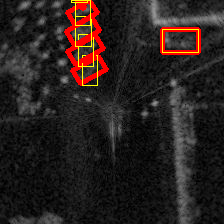

[[162.0, 29.0, 198.0, 29.0, 198.0, 52.0, 162.0, 52.0], [98.83179721236229, 56.065597385168076, 106.24660041928291, 69.10479620099068, 80.16820278763771, 83.93440261483192, 72.75339958071709, 70.89520379900932], [95.43640252947807, 35.38774797320366, 103.08762815594673, 48.289637356996536, 75.56359747052193, 64.61225202679634, 67.91237184405327, 51.710362643003464], [91.92396551370621, 16.53062355518341, 99.98757368326187, 30.35011112689972, 74.07603448629379, 45.46937644481659, 66.01242631673813, 31.64988887310028], [89.28002908825874, -0.40469661355018616, 97.07709893584251, 12.409580200910568, 75.71997091174126, 25.404696613550186, 67.92290106415749, 12.590419799089432], [75.64840489625931, -6.332585453987122, 84.05341321229935, 7.281959414482117, 82.35159510374069, 8.332585453987122, 73.94658678770065, -5.281959414482117]]


In [160]:
from PIL import Image
j = 130
# for i in range(len(x1)):
dataset_g = Radiate_Dataset(data_folder, train_mode, transform=True)
# dataset_g = Radiate_Dataset(data_folder, train_mode, transform=False)


img, target, img_info = dataset_g[j]
# img, target, _ = dataset_g_nt[j]
# print(img_info)
# file_name = target['file_name']
# folder_name = target['folder_name']
# frame_number= target['frame_number']
# train_mode = target['train_mode']
# bbox = target['bboxes']
# category = target['category_id']

img1_p = img
print(img.shape)
# img1_p = img1_p.detach().cpu().numpy()
# img1_p = np.transpose(img1_p, (1,2,0))
img1_p = cv2.cvtColor(img1_p, cv2.COLOR_BGR2RGB)
# img1_p = img1_p.astype(np.uint8).copy()
bboxes = target['bboxes']
# bboxes = np.loadtxt('/workspace/dataset/radiate_yolov5/'+train_mode+'/labels/'+str(j).zfill(6)+'.txt',dtype = np.float32)
# try:
print(target['bboxes'])
print(bboxes)
# print(bbox)
# print(bboxes.shape)

# temp = bbox[:,0:8]
# bbox = temp.astype(np.float32)
bboxes = np.array(bboxes, dtype=np.int32)
bbox.astype(np.int32)
# bboxes = torch.from_numpy(bboxes)
# print(bboxes.size())
# rec = bboxes*1152
# rec = np.int32(rec)
rec = bboxes
# print(rec[0][0], rec[0][1], rec[0][2], rec[0][3])
bbox_OBB = []
for i, _ in enumerate(bboxes):
    # print(bboxes[i])
    points = gen_boundingbox(bboxes[i], target['angle'][i])
    bbox = points.astype(np.int32)
    # print(bbox[0][0], bbox[1][0])
    
    # x1 = points[0][0]
    # y1 = points[1][0]
    # x2 = points[0][1]
    # y2 = points[1][1]
    # x3 = points[0][2]
    # y3 = points[1][2]
    # x4 = points[0][3]
    # y4 = points[1][3]
    # print(rec[i][0])
    x1 = points[0][0]
    y1 = points[1][0]
    x2 = points[0][1]
    y2 = points[1][1]
    x3 = points[0][2]
    y3 = points[1][2]
    x4 = points[0][3]
    y4 = points[1][3]
    bbox_OBB.append([x1, y1, x2, y2, x3, y3, x4, y4])
    cv2.line(img1_p, (bbox[0][0], bbox[1][0]), (bbox[0][1], bbox[1][1]), (255,0,0), 4)
    cv2.line(img1_p, (bbox[0][1], bbox[1][1]), (bbox[0][2], bbox[1][2]), (255,0,0), 4)
    cv2.line(img1_p, (bbox[0][2], bbox[1][2]), (bbox[0][3], bbox[1][3]), (255,0,0), 4)
    cv2.line(img1_p, (bbox[0][3], bbox[1][3]), (bbox[0][0], bbox[1][0]), (255,0,0), 4)
    x1 = int(bboxes[i][0])
    x2 = int(bboxes[i][2])
    y1 = int(bboxes[i][1])
    y2 = int(bboxes[i][3])

    # print(x1, x2, y1, y2)
    cv2.rectangle(img1_p, (x1, y1), (x2, y2), color = (255,255,0))

# break
img1_show = Image.fromarray(img1_p)
img1_show.show()
cv2.imwrite('/workspace/code/yolov5_2/test.png', img1_p)
print(bbox_OBB)
# except:
    
#     if bbox.shape[0] == 10:
#         temp = bbox[0:8]
#         bbox = temp.astype(np.float32)
#         bbox = bbox.astype(np.int32)
#         bboxes = torch.from_numpy(bboxes)
#         # print(bboxes.size())
#         rec = bboxes*1152
#         rec = np.int32(rec)
#         cv2.line(img1_p, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255,0,0), 4)
#         cv2.line(img1_p, (bbox[2], bbox[3]), (bbox[4], bbox[5]), (255,0,0), 4)
#         cv2.line(img1_p, (bbox[4], bbox[5]), (bbox[6], bbox[7]), (255,0,0), 4)
#         cv2.line(img1_p, (bbox[6], bbox[7]), (bbox[0], bbox[1]), (255,0,0), 4)
        
#         x1 = int(rec[1] - rec[3]/2)
#         x2 = int(rec[1] + rec[3]/2)
#         y1 = int(rec[2] - rec[4]/2)
#         y2 = int(rec[2] + rec[4]/2)

#         cv2.rectangle(img1_p, (x1, y1), (x2, y2), color = (255,255,0))
#     img1_show = Image.fromarray(img1_p)
#     img1_show.show()


In [167]:
from tqdm import tqdm

# root_dir = '/workspace/dataset/radiate_centercrop'

os.makedirs(img_save, exist_ok=True)
os.makedirs(label_save, exist_ok=True)
os.makedirs(label_OBB_save, exist_ok=True)
os.makedirs(img_info_save, exist_ok=True)

for i in tqdm(range(len(dataset))):
    
    img, target, img_info= dataset[i]
    file_name = target['file_name']
    # folder_name = target['folder_name']
    # frame_number= target['frame_number']
    # train_mode = target['train_mode']
    bbox = target['bboxes']
    # bbox_OOD = target['bboxes_OOD']
    category = target['category_id']
    # print(category.shape)
    img_save_path = os.path.join(img_save, str(i).zfill(5)+'.png')
    label_save_path = os.path.join(label_save, str(i).zfill(5)+'.txt')
    label_OBB_save_path = os.path.join(label_OBB_save, str(i).zfill(5)+'.txt')
    img_info_save_path = os.path.join(img_info_save, str(i).zfill(5)+'.json')
    
    # print(img_save_path)
    cv2.imwrite(img_save_path, img)
    with open(label_save_path,"w") as f:
        for j in range(category.size(0)):
            # print("%i %.6f %.6f %.6f %.6f" % (category[j], bbox[j][0], bbox[j][1], bbox[j][2], bbox[j][3]))
            # print(str(np.array(category[j]).astype(np.int32)))
            cx = (bbox[j][0] + bbox[j][2]) / 2
            cy = (bbox[j][1] + bbox[j][3]) / 2
            wid = bbox[j][2] - bbox[j][0]
            hei = bbox[j][3] - bbox[j][1]
                
            f.write("%i %.6f %.6f %.6f %.6f \n" % (category[j], cx, cy, wid, hei))
    
    with open(label_OBB_save_path,"w") as f:
        bbox_OBB = []
        for k, HBB in enumerate(bbox):
            points = gen_boundingbox(HBB, target['angle'][k])
            x1 = points[0][0]
            y1 = points[1][0]
            x2 = points[0][1]
            y2 = points[1][1]
            x3 = points[0][2]
            y3 = points[1][2]
            x4 = points[0][3]
            y4 = points[1][3]
            if x1 < 0:
                x1 = 0
            if x2 < 0:
                x2 = 0
            if x3 < 0:
                x3 = 0
            if x4 < 0:
                x4 = 0
            if y1 < 0:
                y1 = 0
            if y2 < 0:
                y2 = 0
            if y3 < 0:
                y3 = 0
            if y4 < 0:
                y4 = 0
            bbox_OBB.append([x1, y1, x2, y2, x3, y3, x4, y4])
        for j in range(category.size(0)):
            # print("%i %.6f %.6f %.6f %.6f" % (category[j], bbox[j][0], bbox[j][1], bbox[j][2], bbox[j][3]))
            # print(str(np.array(category[j]).astype(np.int32)))
            f.write("%.1f %.1f %.1f %.1f %.1f %.1f %.1f %.1f vehicle %i \n" % (bbox_OBB[j][0], bbox_OBB[j][1], bbox_OBB[j][2], bbox_OBB[j][3], bbox_OBB[j][4], bbox_OBB[j][5], bbox_OBB[j][6], bbox_OBB[j][7], 0))
    
    with open(img_info_save_path, 'w', encoding='utf-8') as f:
        json.dump(img_info, f)
        
    if i == 130:
        break

  1%|          | 130/22371 [00:02<06:52, 53.96it/s]


In [179]:
from PIL import Image
train_mode = 'train_good_and_bad_weather'
root_dir = '/workspace/dataset/radiate_centercrop'
# dataset = Radiate_Dataset(data_folder, train_mode, transform=True)

img_save = os.path.join(root_dir, train_mode, 'images')
label_save = os.path.join(root_dir, train_mode, 'labels')
label_OBB_save = os.path.join(root_dir, train_mode, 'labelTxt')
img_info_save = os.path.join(root_dir, train_mode, 'img_info')
i = 9590
img = cv2.imread(os.path.join(img_save, str(i).zfill(5)+'.png'))
labels = np.loadtxt(os.path.join(label_save,str(i).zfill(5)+'.txt'),dtype = np.float32)
labels_OBB = np.loadtxt(os.path.join(label_OBB_save,str(i).zfill(5)+'.txt'), dtype=str)
print(labels)
print(labels_OBB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

temp = labels_OBB[:,0:8]
bbox = temp.astype(np.float32)
bbox = bbox.astype(np.int32)
OBB = torch.from_numpy(bboxes)
print(OBB.shape)
for i, label in enumerate(labels):
    x_min = label[1] - label[3] / 2
    x_max = label[1] + label[3] / 2
    y_min = label[2] - label[4] / 2
    y_max = label[2] + label[4] / 2
    cv2.line(img, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), (255,0,255), 3)
    cv2.line(img, (bbox[i][2], bbox[i][3]), (bbox[i][4], bbox[i][5]), (255,0,255), 3)
    cv2.line(img, (bbox[i][4], bbox[i][5]), (bbox[i][6], bbox[i][7]), (255,0,255), 3)
    cv2.line(img, (bbox[i][6], bbox[i][7]), (bbox[i][0], bbox[i][1]), (255,0,255), 3)
    x_min, y_min, x_max, y_max = np.int32(x_min), np.int32(y_min), np.int32(x_max), np.int32(y_max)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255,0,0), 1)
    
img1_show = Image.fromarray(img)
img1_show.show()

[]
[]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "/workspace/dataset/radiate_centercrop/train_good_and_bad_weather/labels/09590.txt"
  if sys.path[0] == "":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "/workspace/dataset/radiate_centercrop/train_good_and_bad_weather/labelTxt/09590.txt"
  del sys.path[0]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed